In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
pickle_file = 'SVHN.pickle'

train_size = 10000
valid_size = 1000
test_size = 1000

with open(pickle_file, 'rb') as f:
    tmp_save = pickle.load(f)
    tmp_train_dataset = tmp_save['train_dataset'][:train_size]
    tmp_train_labels = tmp_save['train_labels'][:train_size]
    tmp_valid_dataset = tmp_save['valid_dataset'][:valid_size]
    tmp_valid_labels = tmp_save['valid_labels'][:valid_size]
    tmp_test_dataset = tmp_save['test_dataset'][:test_size]
    tmp_test_labels = tmp_save['test_labels'][:test_size]
    
    print('Training set', tmp_train_dataset.shape, tmp_train_labels.shape)
    print('Validation set', tmp_valid_dataset.shape, tmp_valid_labels.shape)
    print('Test set', tmp_test_dataset.shape, tmp_test_labels.shape)
    del tmp_save
    

In [ ]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])
    
show_images(tmp_train_dataset, tmp_train_labels, 1)
show_images(tmp_valid_dataset, tmp_valid_labels, 1)
show_images(tmp_test_dataset, tmp_test_labels, 1)

In [9]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale
num_digits = 5

import numpy as np

def convert_label(label):
    return [2,3]

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

train_dataset, train_labels = reformat(tmp_train_dataset, tmp_train_labels)
valid_dataset, valid_labels = reformat(tmp_valid_dataset, tmp_valid_labels)
test_dataset, test_labels = reformat(tmp_test_dataset, tmp_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (10000, 90, 160, 1) (10000, 5, 11)
Validation set (1000, 90, 160, 1) (1000, 5, 11)
Test set (1000, 90, 160, 1) (1000, 5, 11)


Labels [2 2]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


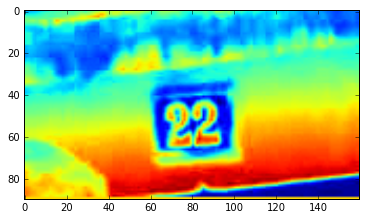

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Labels [1 4]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


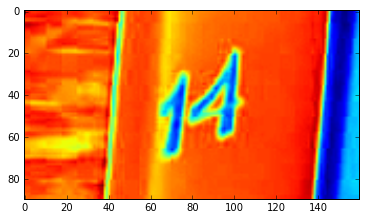

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Labels [4]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


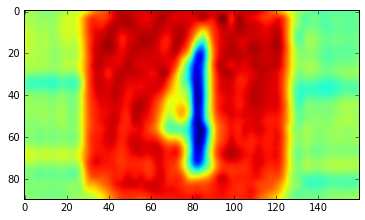

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [11]:
for i in np.random.choice(range(tmp_train_labels.shape[0]), 3):
    show_image(tmp_train_dataset[i], tmp_train_labels[i])
    print(train_labels[i])

In [12]:
# Clean up after ourselves
%reset_selective -f tmp_.*

In [17]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                      patch_size,
                                                      num_channels,
                                                      depth], stddev=0.1), name="layer1_weights")
    layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                      patch_size,
                                                      depth,
                                                      depth], stddev=0.1), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="layer2_biases")

    
    layer3_weights = tf.Variable(tf.truncated_normal([int(round(img_height / 4.)) * int(round(img_width / 4.)) * depth,
                                                      num_hidden], stddev=0.1), name="layer3_weights")    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="layer3_biases")
    

    layer4_weights = [tf.Variable(tf.truncated_normal([num_hidden,
                                                       num_labels], stddev=0.1), name="layer4_weights")
                    for i in range(num_digits)]
    layer4_biases = [tf.Variable(tf.constant(1.0, shape=[num_labels]), name="layer4_biases")
                   for i in range(num_digits)]



    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        output = [tf.matmul(hidden, layer4_weights[i]) + layer4_biases[i]
                  for i in range(num_digits)]
        return output

    # Training computation.
    logits = model(tf_train_dataset)
    
    loss = tf.reduce_mean([tf.nn.softmax_cross_entropy_with_logits(logits[i], 
                                                                   tf_train_labels[i])
        for i in range(num_digits)])

    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1001, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(a) for a in logits]
    valid_prediction = [tf.nn.softmax(a) for a in model(tf_valid_dataset)]
    test_prediction = [tf.nn.softmax(a) for a in model(tf_test_dataset)]

In [18]:
num_steps = 1001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):    

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data}
        for i in range(num_digits):
            labels = batch_labels[:, i, :]
            feed_dict[tf_train_labels[i]] = labels

        fetches = [optimizer, loss] + train_prediction
        results = session.run(fetches, feed_dict=feed_dict)
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, results[1]))               
            print('Minibatch accuracy: %.1f%%' % np.mean([accuracy(results[2+i], batch_labels[:, i, :])
                                                        for i in range(num_digits)]))
            print('Validation accuracy: %.1f%%' % np.mean([accuracy(valid_prediction[i].eval(),
                                                                  valid_labels[:, i, :])
                                                         for i in range(num_digits)]))
            
        # Free up some memory
        %reset_selective -f batch_data
        %reset_selective -f batch_labels
        
    # Lets get these so we can investigate the predictions outside of the graph
    test_predictions = [test_prediction[i].eval()
                        for i in range(num_digits)]
    
    print('Test accuracy: %.1f%%' % np.mean([accuracy(test_predictions[i],
                                                      test_labels[:, i, :])
                                             for i in range(num_digits)]))

Initialized
Minibatch loss at step 0: 11.307899
Minibatch accuracy: 6.2%
Validation accuracy: 58.6%
Minibatch loss at step 50: 1.326263
Minibatch accuracy: 55.0%
Validation accuracy: 61.0%
Minibatch loss at step 100: 1.241307
Minibatch accuracy: 58.8%
Validation accuracy: 59.9%
Minibatch loss at step 150: 1.220051
Minibatch accuracy: 60.0%
Validation accuracy: 58.4%
Minibatch loss at step 200: 1.219064
Minibatch accuracy: 60.0%
Validation accuracy: 61.0%
Minibatch loss at step 250: 1.216770
Minibatch accuracy: 62.5%
Validation accuracy: 58.2%
Minibatch loss at step 300: 1.355826
Minibatch accuracy: 51.2%
Validation accuracy: 59.5%
Minibatch loss at step 350: 1.238676
Minibatch accuracy: 60.0%
Validation accuracy: 59.7%
Minibatch loss at step 400: 1.214251
Minibatch accuracy: 62.5%
Validation accuracy: 61.0%
Minibatch loss at step 450: 1.284708
Minibatch accuracy: 60.0%
Validation accuracy: 61.0%
Minibatch loss at step 500: 1.302980
Minibatch accuracy: 57.5%
Validation accuracy: 61.0%
M

In [35]:
batch_size = 16
patch_size = 5

layers = [[5, 5, 1, 4],
          [4, 4, 4, 8],
          [4, 4, 8, 12]]

hidden = 200

graph = tf.Graph()

img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    
    
    c_weights = [tf.Variable(tf.truncated_normal(layer, stddev=0.1), name="c_weights_%d" % i)
                 for i, layer in enumerate(layers)]
    c_biases = [tf.Variable(tf.ones(layer[3])/10, name="c_biases_%d" % i)
                for i, layer in enumerate(layers)]
    
    
    fc_weights = tf.Variable(tf.truncated_normal([12*20*layers[-1][3], hidden], stddev=0.1), name='fc_weights')
    fc_biases = tf.Variable(tf.ones(hidden)/10, name="fc_biases")

      

    digit_weights = [tf.Variable(tf.truncated_normal([num_hidden,
                                                      num_labels], stddev=0.1), name="digit_weights_%d" % i)
                    for i in range(num_digits)]
    digit_biases = [tf.Variable(tf.zeros(num_labels)/10, name="digit_biases_%d" % i)
                    for i in range(num_digits)]



    # Model.
    def model(tf_input):
        
        Y = tf_input
        for i in range(len(c_weights)):
            print(Y.get_shape().as_list())
            Y = tf.nn.relu(tf.nn.conv2d(Y, c_weights[i], [1, 2, 2, 1], padding='SAME') + c_biases[i])
        print(Y.get_shape().as_list())
        
        shape = Y.get_shape().as_list()
        Y = tf.reshape(Y, [shape[0], shape[1] * shape[2] * shape[3]])
        print(Y.get_shape().as_list())

        
        Y = tf.nn.relu(tf.matmul(Y, fc_weights) + fc_biases)
        
        output = [tf.matmul(Y, digit_weights[i]) + digit_biases[i]
                  for i in range(num_digits)]
        return output


    # Training computation.
    logits = model(tf_train_dataset)
    
    # Lets add the for each digit together
    loss = tf.add_n([tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[i], 
                                                                   tf_train_labels[i]))
        for i in range(num_digits)])

    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 1001, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(a) for a in logits]
    valid_prediction = [tf.nn.softmax(a) for a in model(tf_valid_dataset)]
    test_prediction = [tf.nn.softmax(a) for a in model(tf_test_dataset)]

[16, 90, 160, 1]
[16, 45, 80, 4]
[16, 23, 40, 8]
[16, 12, 20, 12]
[16, 2880]
[1000, 90, 160, 1]
[1000, 45, 80, 4]
[1000, 23, 40, 8]
[1000, 12, 20, 12]
[1000, 2880]
[1000, 90, 160, 1]
[1000, 45, 80, 4]
[1000, 23, 40, 8]
[1000, 12, 20, 12]
[1000, 2880]


In [36]:
num_steps = 501

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):    

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data}
        for i in range(num_digits):
            labels = batch_labels[:, i, :]
            feed_dict[tf_train_labels[i]] = labels

        fetches = [optimizer, loss] + train_prediction
        results = session.run(fetches, feed_dict=feed_dict)
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, results[1]))               
            print('Minibatch accuracy: %.1f%%' % np.mean([accuracy(results[2+i], batch_labels[:, i, :])
                                                        for i in range(num_digits)]))
            print('Validation accuracy: %.1f%%' % np.mean([accuracy(valid_prediction[i].eval(),
                                                                  valid_labels[:, i, :])
                                                         for i in range(num_digits)]))
            
        # Free up some memory
        %reset_selective -f batch_data
        %reset_selective -f batch_labels
        
    # Lets get these so we can investigate the predictions outside of the graph
    test_predictions = [test_prediction[i].eval()
                        for i in range(num_digits)]
    
    print('Test accuracy: %.1f%%' % np.mean([accuracy(test_predictions[i],
                                                      test_labels[:, i, :])
                                             for i in range(num_digits)]))

Initialized
Minibatch loss at step 0: 11.239649
Minibatch accuracy: 21.2%
Validation accuracy: 58.6%
Minibatch loss at step 50: 6.401561
Minibatch accuracy: 65.0%
Validation accuracy: 61.0%
Minibatch loss at step 100: 6.199816
Minibatch accuracy: 58.8%
Validation accuracy: 60.1%
Minibatch loss at step 150: 6.044143
Minibatch accuracy: 58.8%
Validation accuracy: 59.7%
Minibatch loss at step 200: 6.059979
Minibatch accuracy: 60.0%
Validation accuracy: 61.0%
Minibatch loss at step 250: 5.929366
Minibatch accuracy: 58.8%
Validation accuracy: 59.8%
Minibatch loss at step 300: 6.715488
Minibatch accuracy: 55.0%
Validation accuracy: 61.0%
Minibatch loss at step 350: 6.250300
Minibatch accuracy: 58.8%
Validation accuracy: 59.6%
Minibatch loss at step 400: 6.213416
Minibatch accuracy: 62.5%
Validation accuracy: 61.0%
Minibatch loss at step 450: 6.420418
Minibatch accuracy: 60.0%
Validation accuracy: 61.0%
Minibatch loss at step 500: 6.242770
Minibatch accuracy: 57.5%
Validation accuracy: 61.0%
